In [2]:
%matplotlib inline

import numpy as np
from pprint import pprint

from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import grad
from torch.utils.data import DataLoader, Subset
import torch.optim as optim
import torchvision
from torchvision import models, datasets, transforms
import random
from tqdm import tqdm
import torch
from torch.autograd.functional import jvp
from defense import *
torch.manual_seed(50)

batch_size = 2
idx = 30

import inversefed
setup = inversefed.utils.system_startup()
defs = inversefed.training_strategy('conservative')

loss_fn, trainloader, validloader =  inversefed.construct_dataloaders('CIFAR10', defs)



print(torch.__version__, torchvision.__version__)

dst = validloader.dataset


train_indices = list(range(idx, idx + batch_size))
train_subset = Subset(dst, train_indices)
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=False)

test_indices = list(range(len(dst)))
test_subset = Subset(dst, test_indices)
test_loader = DataLoader(test_subset, batch_size=batch_size, shuffle=False)

device = "cpu"
if torch.cuda.is_available():
    device = "cuda"
print("Running on %s" % device)



Currently evaluating -------------------------------:
Friday, 04. October 2024 01:54PM
CPUs: 14, GPUs: 1 on LAPTOP-HS456NH3.
GPU : NVIDIA GeForce RTX 2050
Files already downloaded and verified
Files already downloaded and verified
2.0.1+cu118 0.15.2+cu118
Running on cuda


In [3]:
import inversefed
arch = 'ConvNet32'

net, _ = inversefed.construct_model(arch, num_classes=10, num_channels=3,seed=0)

print('Num of Parameters Total')
print(sum(p.numel() for p in net.parameters() if p.requires_grad))

Model initialized with random key 0.
Num of Parameters Total
2904970


In [ ]:
batch_size = 8
split_batch=4
test_loader=train_loader
defense_method = lambda x,y,z,w: defense_dpsgd(x,y,z,w,clipping_threshold=0.05)
defense_method = defense_prune
num_epoch = 10
lr = 1e-3

for noise_scale in [0.1,0.2,0.3,0.4,0.5,0.6,0.7]:
    for num_samples in [10]: #Num samples for random sketching
        for defense_type in ['default','ours']:
            train_indices = list(range(1,9))
            train_subset = Subset(dst, train_indices)
            train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=False)

            test_indices = list(range(1,9))
            test_subset = Subset(dst, test_indices)
            test_loader = DataLoader(test_subset, batch_size=batch_size, shuffle=False)
            print(f'\n\n\n\n___^^^___noise_scale:{noise_scale}, defense_method:{defense_type}___^^^___')

            torch.manual_seed(0)
            net, _ = inversefed.construct_model(arch, num_classes=10, num_channels=3, seed=0)
            net.to(device)
            loss = []
            acc = []
            norms = []
            defense = True
            optimizer = optim.SGD(net.parameters(), lr=lr)
            criterion = lambda x,y: loss_fn(x,y)[0]#torch.nn.CrossEntropyLoss()
            for _ in range(num_epoch):
                print(f'______EPOCH {_+1}_______')
                t=tqdm(train_loader)
                for gt_data, gt_label in t:
                    gt_data, gt_label = gt_data.to(device), gt_label.to(device)
                    gt_onehot_label = label_to_onehot(gt_label, num_classes=10)

                    optimizer.zero_grad()

                    split_size = batch_size // split_batch
                    parts_data = torch.split(gt_data, split_size)
                    parts_label = torch.split(gt_label, split_size)
                    parts_onehot_label = torch.split(gt_onehot_label, split_size)

                    accumulated_gradients = None

                    for part_data, part_label, part_onehot_label in zip(parts_data, parts_label, parts_onehot_label):
                        part_data.requires_grad_(True)
                        out = net(part_data)
                        y = criterion(out, part_label)
                        original_dy_dx = torch.autograd.grad(y, net.parameters(), create_graph=True)
                        l2_norms_dy_dx=None

                        if defense:
                            if defense_type != 'default':
                                l2_norms_dy_dx = compute_l2_norm_of_gradients_new(net, part_data, part_onehot_label, criterion, num_samples=num_samples)
                            modified_dy_dx = defense_method(original_dy_dx, l2_norms_dy_dx, noise_scale, defense_type)
                            # print(sum([torch.sum(i==0) for i in modified_dy_dx])/sum([torch.numel(i) for i in modified_dy_dx]))
                        else:
                            modified_dy_dx = original_dy_dx

                        if accumulated_gradients is None:
                            accumulated_gradients = [grad.clone() for grad in modified_dy_dx]
                        else:
                            for i in range(len(accumulated_gradients)):
                                accumulated_gradients[i] += modified_dy_dx[i]

                    for i in range(len(accumulated_gradients)):
                        accumulated_gradients[i] /= split_batch

                    with torch.no_grad():
                        for param, grad in zip(net.parameters(), accumulated_gradients):
                            param.grad = grad
                    optimizer.step()

                    loss.append(y.item())
                    acc.append((torch.argmax(net(gt_data), dim=1) == gt_label).float().mean().item())
                    if defense and defense_type=='ours':
                        norms.append([(torch.mean(torch.abs(l2_norms_dy_dx[i] / original_dy_dx[i])) ** 0.5).item() for i in range(len(original_dy_dx))])
                    t.set_description(f"Loss: {loss[-1]}, Acc: {acc[-1]}")

            epoch_test_loss = 0
            epoch_test_acc = 0
            with torch.no_grad():
                for test_data, test_label in test_loader:
                    test_data, test_label = test_data.to(device), test_label.to(device)
                    test_out = net(test_data)
                    test_y = criterion(test_out, test_label)
                    epoch_test_loss += test_y.item()
                    epoch_test_acc += (torch.argmax(test_out, dim=1) == test_label).float().mean().item()

            final_test_loss=epoch_test_loss / len(test_loader)
            final_test_acc=epoch_test_acc / len(test_loader)
            print(f"Final Test Loss: {final_test_loss}, Final Test Acc: {final_test_acc}")

            epoch_train_loss = 0
            epoch_train_acc = 0
            with torch.no_grad():
                for test_data, test_label in train_loader:
                    test_data, test_label = test_data.to(device), test_label.to(device)
                    test_out = net(test_data)
                    test_y = criterion(test_out, test_label)
                    epoch_train_loss += test_y.item()
                    epoch_train_acc += (torch.argmax(test_out, dim=1) == test_label).float().mean().item()

            final_train_loss=epoch_train_loss / len(train_loader)
            final_train_acc=epoch_train_acc / len(train_loader)
            print(f"Final Train Loss: {final_train_loss}, Final Train Acc: {final_train_acc}")
            
            with open('data_train_detail.txt', 'a') as file:
                file.write(f"k: {noise_scale}, Defense type: {defense_type}\nLoss: {loss}\nAcc: {acc}\n\n")

            with open('data_train.txt', 'a') as file:
                file.write(f"Final train loss: {final_train_loss}, Final test loss: {final_test_loss}, Final train acc: {final_train_acc}, Final test acc: {final_test_acc}, k: {noise_scale}, Defense type: {defense_type}, Num_Samples: {num_samples}\n")

: 

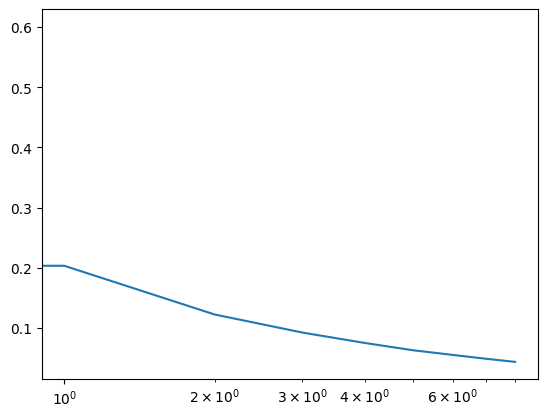

In [9]:
plt.figure()
sum_range=1
toplot=loss
plt.plot([np.sum(toplot[max(0, i-sum_range+1):i+1]) for i in range(sum_range,len(toplot))])
plt.xscale('log')
plt.show()

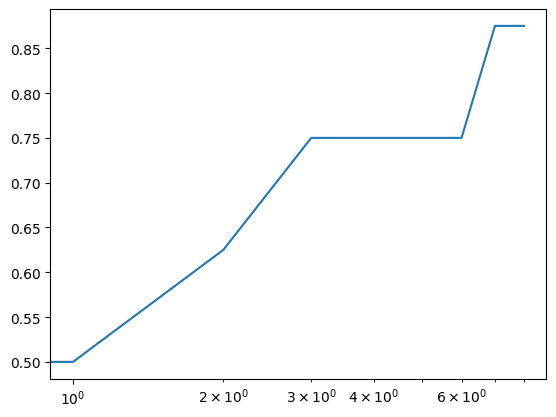

In [10]:
plt.figure()
sum_range=1
toplot=acc
plt.plot([np.sum(toplot[max(0, i-sum_range+1):i+1])/sum_range for i in range(sum_range,len(toplot))])
plt.xscale('log')
plt.show()

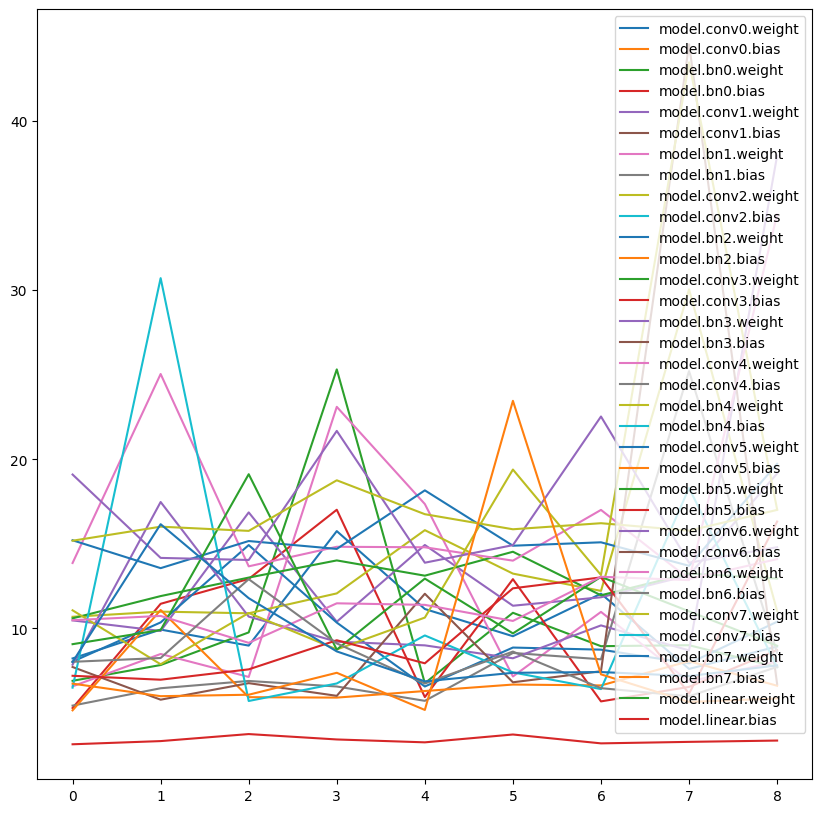

In [11]:
#For Mean Noise Scale of All Parameters
plt.figure(figsize=(10,10))
sum_range=1

for _,pair in enumerate(net.named_parameters()):
    if True:
        name,param=pair
        toplot=[x[_] for x in norms]
        plt.plot([np.sum(toplot[max(0, i-sum_range+1):i+1]) for i in range(sum_range,len(toplot))],label=name)
plt.legend()
plt.show()
# for _ in range(len(norms[0])):
#     toplot=[x[_] for x in norms]
#     plt.plot([np.sum(toplot[max(0, i-sum_range+1):i+1]) for i in range(sum_range,len(toplot))])
# plt.show()

In [ ]:
for _ in range(len(norms[0])):
    print(sum([x[_] for x in norms]))

In [ ]:
list(norms[0])

[inf,
 2.6669578552246094,
 inf,
 2.265286922454834,
 inf,
 2.4916810989379883,
 inf,
 1.6190457344055176,
 inf,
 inf]

In [20]:
test_loader=train_loader
defense_method = defense_prune 
num_epoch = 10
lr = 1e-5

for noise_scale in [0.01,0.02,0.05,0.1,0.2,0.4,0.6,0.8,0.9,0.99]:
    for idx_start in [1]:
        for num_samples in [10]: #Num samples for random sketching
            for defense_type in ['ours','default']:
                idx=idx_start
                train_indices = list(range(idx, idx + 10*batch_size))
                train_subset = Subset(dst, train_indices)
                train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=False)

                test_loader = train_loader
                # if noise_scale==1e-4 and defense_type=='ours':
                #     continue
                print(f'\n\n\n\n___^^^___noise_scale:{noise_scale}, defense_method:{defense_type}___^^^___')

                # net = SimpleCNN().to(device)

                net, _ = inversefed.construct_model(arch, num_classes=10, num_channels=3,seed=0)
                net.to(device)
                # Model, optimizer and other parameters
                loss = []
                acc = []
                norms = []
                defense = True
                optimizer = optim.SGD(net.parameters(), lr=lr)
                criterion = torch.nn.CrossEntropyLoss()
                # criterion = cross_entropy_for_onehot

                # Training loop
                for _ in range(num_epoch):
                    print(f'______EPOCH {_+1}_______')
                    trigger=0
                    t=tqdm(train_loader)
                    for gt_data, gt_label in t:
                        gt_data, gt_label = gt_data.to(device), gt_label.to(device)
                        gt_onehot_label = label_to_onehot(gt_label, num_classes=10)
                        gt_data.requires_grad_(True)
                        # print(next(net.parameters())[0])

                        optimizer.zero_grad()  # Zero the gradients
                        # print(gt_data.shape)

                        out = net(gt_data)
                        # y = criterion(out, gt_onehot_label)
                        y = criterion(out, gt_label)
                        # assert not np.isnan(y.item())
                        # print(y)
                        # raise AssertionError
                        original_dy_dx = torch.autograd.grad(y, net.parameters())
                        l2_norms_dy_dx = None

                        # for qien in original_dy_dx:
                        #     assert not torch.isnan(qien).any()
                        # y.backward()
                        # original_dy_dx=[param.grad for param in net.parameters()]
                        # print(list(x for x in original_dy_dx)[1])

                        if defense:
                            if trigger == 0 and defense_type=='ours':
                                l2_norms_dy_dx = compute_l2_norm_of_gradients_new(net, gt_data, gt_onehot_label, criterion,num_samples=num_samples)
                                # for qien in l2_norms_dy_dx:
                                #     assert not torch.isnan(qien).any()
                                trigger=-1
                            modified_dy_dx = defense_method(original_dy_dx, l2_norms_dy_dx, noise_scale, defense_type)
                            trigger+=1
                        else:
                            modified_dy_dx = original_dy_dx


                        # Apply gradients manually if defense is enabled, else use optimizer step
                        with torch.no_grad():
                            for param, grad in zip(net.parameters(), modified_dy_dx):
                                param.grad = grad  # Manually set the gradients
                        # print(net.body[0].bias.grad)
                        # raise AssertionError
                        optimizer.step()  # Update the parameters using Adam optimizer

                        loss.append(y.item())
                        acc.append((torch.argmax(out, dim=1) == gt_label).float().mean().item())
                        if defense and defense_type=='ours':
                            norms.append([(torch.mean(torch.abs(l2_norms_dy_dx[i] / original_dy_dx[i])) ** 0.5).item() for i in range(len(original_dy_dx))])
                        t.set_description(f"Loss: {loss[-1]}, Acc_30: {sum(acc[-30:])/30}")

                # net.eval()  # Set the model to evaluation mode
                epoch_test_loss = 0
                epoch_test_acc = 0
                with torch.no_grad():
                    for test_data, test_label in test_loader:
                        test_data, test_label = test_data.to(device), test_label.to(device)
                        test_out = net(test_data)
                        test_y = criterion(test_out, test_label)
                        epoch_test_loss += test_y.item()
                        epoch_test_acc += (torch.argmax(test_out, dim=1) == test_label).float().mean().item()

                final_test_loss=epoch_test_loss / len(test_loader)
                final_test_acc=epoch_test_acc / len(test_loader)
                print(f"Final Test Loss: {final_test_loss}, Final Test Acc: {final_test_acc}")

                epoch_train_loss = 0
                epoch_train_acc = 0
                with torch.no_grad():
                    for test_data, test_label in train_loader:
                        test_data, test_label = test_data.to(device), test_label.to(device)
                        test_out = net(test_data)
                        test_y = criterion(test_out, test_label)
                        epoch_train_loss += test_y.item()
                        print( (torch.argmax(test_out, dim=1) == test_label).float().mean().item())
                        epoch_train_acc += (torch.argmax(test_out, dim=1) == test_label).float().mean().item()

                final_train_loss=epoch_train_loss / len(train_loader)
                final_train_acc=epoch_train_acc / len(train_loader)
                print(f"Final Train Loss: {final_train_loss}, Final Train Acc: {final_train_acc}")

                with open('data_train.txt', 'a') as file:
                    file.write(f"Final train loss: {final_train_loss}, Final test loss: {final_test_loss}, Final train acc: {final_train_acc}, Final test acc: {final_test_acc}, k: {noise_scale}, Defense type: {defense_type}, Num_Samples: {num_samples}, idx:{idx_start}\n")





___^^^___noise_scale:0.01, defense_method:ours___^^^___
Model initialized with random key 0.
______EPOCH 1_______


Loss: 2.8259458541870117, Acc_30: 0.041666666666666664: 100%|██████████| 10/10 [00:04<00:00,  2.35it/s]


______EPOCH 2_______


Loss: 2.7367467880249023, Acc_30: 0.0875: 100%|██████████| 10/10 [00:04<00:00,  2.25it/s]            


______EPOCH 3_______


Loss: 2.6523141860961914, Acc_30: 0.1375: 100%|██████████| 10/10 [00:04<00:00,  2.28it/s]           


______EPOCH 4_______


Loss: 2.5725505352020264, Acc_30: 0.15416666666666667: 100%|██████████| 10/10 [00:04<00:00,  2.35it/s]


______EPOCH 5_______


Loss: 2.4945592880249023, Acc_30: 0.17916666666666667: 100%|██████████| 10/10 [00:04<00:00,  2.27it/s]


______EPOCH 6_______


Loss: 2.42044997215271, Acc_30: 0.2125: 100%|██████████| 10/10 [00:04<00:00,  2.22it/s]              


______EPOCH 7_______


Loss: 2.349820852279663, Acc_30: 0.24166666666666667: 100%|██████████| 10/10 [00:04<00:00,  2.21it/s]


______EPOCH 8_______


Loss: 2.283351182937622, Acc_30: 0.26666666666666666: 100%|██████████| 10/10 [00:04<00:00,  2.35it/s]


______EPOCH 9_______


Loss: 2.220137119293213, Acc_30: 0.2916666666666667: 100%|██████████| 10/10 [00:04<00:00,  2.35it/s] 


______EPOCH 10_______


Loss: 2.158660650253296, Acc_30: 0.31666666666666665: 100%|██████████| 10/10 [00:03<00:00,  2.59it/s]


Final Test Loss: 2.0553178071975706, Final Test Acc: 0.3875
0.25
0.75
0.5
0.375
0.25
0.375
0.375
0.25
0.5
0.25
Final Train Loss: 2.0553178071975706, Final Train Acc: 0.3875




___^^^___noise_scale:0.01, defense_method:default___^^^___
Model initialized with random key 0.
______EPOCH 1_______


Loss: 2.8255221843719482, Acc_30: 0.041666666666666664: 100%|██████████| 10/10 [00:00<00:00, 113.62it/s]


______EPOCH 2_______


Loss: 2.7366199493408203, Acc_30: 0.0875: 100%|██████████| 10/10 [00:00<00:00, 109.87it/s]   


______EPOCH 3_______


Loss: 2.6519432067871094, Acc_30: 0.1375: 100%|██████████| 10/10 [00:00<00:00, 90.24it/s]    


______EPOCH 4_______


Loss: 2.5717594623565674, Acc_30: 0.15416666666666667: 100%|██████████| 10/10 [00:00<00:00, 80.64it/s]


______EPOCH 5_______


Loss: 2.4937663078308105, Acc_30: 0.17916666666666667: 100%|██████████| 10/10 [00:00<00:00, 80.59it/s]


______EPOCH 6_______


Loss: 2.4201297760009766, Acc_30: 0.2125: 100%|██████████| 10/10 [00:00<00:00, 76.19it/s]            


______EPOCH 7_______


Loss: 2.349940538406372, Acc_30: 0.24583333333333332: 100%|██████████| 10/10 [00:00<00:00, 69.73it/s]


______EPOCH 8_______


Loss: 2.2827088832855225, Acc_30: 0.2708333333333333: 100%|██████████| 10/10 [00:00<00:00, 69.33it/s]


______EPOCH 9_______


Loss: 2.2196149826049805, Acc_30: 0.29583333333333334: 100%|██████████| 10/10 [00:00<00:00, 69.00it/s]


______EPOCH 10_______


Loss: 2.158358097076416, Acc_30: 0.31666666666666665: 100%|██████████| 10/10 [00:00<00:00, 68.24it/s]


Final Test Loss: 2.055081069469452, Final Test Acc: 0.3875
0.25
0.75
0.5
0.375
0.25
0.375
0.375
0.25
0.5
0.25
Final Train Loss: 2.055081069469452, Final Train Acc: 0.3875




___^^^___noise_scale:0.02, defense_method:ours___^^^___
Model initialized with random key 0.
______EPOCH 1_______


Loss: 2.825350046157837, Acc_30: 0.041666666666666664: 100%|██████████| 10/10 [00:04<00:00,  2.19it/s]


______EPOCH 2_______


Loss: 2.7372801303863525, Acc_30: 0.0875: 100%|██████████| 10/10 [00:04<00:00,  2.24it/s]            


______EPOCH 3_______


Loss: 2.6522042751312256, Acc_30: 0.1375: 100%|██████████| 10/10 [00:04<00:00,  2.24it/s]            


______EPOCH 4_______


Loss: 2.5717883110046387, Acc_30: 0.15416666666666667: 100%|██████████| 10/10 [00:04<00:00,  2.34it/s]


______EPOCH 5_______


Loss: 2.494647264480591, Acc_30: 0.17916666666666667: 100%|██████████| 10/10 [00:04<00:00,  2.26it/s]


______EPOCH 6_______


Loss: 2.420292615890503, Acc_30: 0.2125: 100%|██████████| 10/10 [00:04<00:00,  2.19it/s]             


______EPOCH 7_______


Loss: 2.3504745960235596, Acc_30: 0.24166666666666667: 100%|██████████| 10/10 [00:04<00:00,  2.22it/s]


______EPOCH 8_______


Loss: 2.283710479736328, Acc_30: 0.26666666666666666: 100%|██████████| 10/10 [00:04<00:00,  2.26it/s]


______EPOCH 9_______


Loss: 2.2201905250549316, Acc_30: 0.2916666666666667: 100%|██████████| 10/10 [00:04<00:00,  2.31it/s]


______EPOCH 10_______


Loss: 2.1589677333831787, Acc_30: 0.31666666666666665: 100%|██████████| 10/10 [00:04<00:00,  2.38it/s]


Final Test Loss: 2.056022560596466, Final Test Acc: 0.375
0.25
0.75
0.5
0.375
0.25
0.375
0.375
0.25
0.375
0.25
Final Train Loss: 2.056022560596466, Final Train Acc: 0.375




___^^^___noise_scale:0.02, defense_method:default___^^^___
Model initialized with random key 0.
______EPOCH 1_______


Loss: 2.8258180618286133, Acc_30: 0.041666666666666664: 100%|██████████| 10/10 [00:00<00:00, 81.62it/s]


______EPOCH 2_______


Loss: 2.73688006401062, Acc_30: 0.0875: 100%|██████████| 10/10 [00:00<00:00, 69.02it/s]              


______EPOCH 3_______


Loss: 2.6518869400024414, Acc_30: 0.1375: 100%|██████████| 10/10 [00:00<00:00, 65.72it/s]            


______EPOCH 4_______


Loss: 2.5716934204101562, Acc_30: 0.15416666666666667: 100%|██████████| 10/10 [00:00<00:00, 79.25it/s]


______EPOCH 5_______


Loss: 2.4941389560699463, Acc_30: 0.17916666666666667: 100%|██████████| 10/10 [00:00<00:00, 75.15it/s]


______EPOCH 6_______


Loss: 2.4202589988708496, Acc_30: 0.2125: 100%|██████████| 10/10 [00:00<00:00, 69.04it/s]            


______EPOCH 7_______


Loss: 2.3499679565429688, Acc_30: 0.24166666666666667: 100%|██████████| 10/10 [00:00<00:00, 62.75it/s]


______EPOCH 8_______


Loss: 2.282726764678955, Acc_30: 0.26666666666666666: 100%|██████████| 10/10 [00:00<00:00, 59.82it/s]


______EPOCH 9_______


Loss: 2.219982862472534, Acc_30: 0.2916666666666667: 100%|██████████| 10/10 [00:00<00:00, 57.24it/s]


______EPOCH 10_______


Loss: 2.1582534313201904, Acc_30: 0.31666666666666665: 100%|██████████| 10/10 [00:00<00:00, 62.89it/s]


Final Test Loss: 2.055216348171234, Final Test Acc: 0.375
0.25
0.75
0.5
0.375
0.25
0.375
0.375
0.25
0.375
0.25
Final Train Loss: 2.055216348171234, Final Train Acc: 0.375




___^^^___noise_scale:0.05, defense_method:ours___^^^___
Model initialized with random key 0.
______EPOCH 1_______


Loss: 2.8256447315216064, Acc_30: 0.041666666666666664: 100%|██████████| 10/10 [00:04<00:00,  2.37it/s]


______EPOCH 2_______


Loss: 2.737259864807129, Acc_30: 0.0875: 100%|██████████| 10/10 [00:04<00:00,  2.29it/s]             


______EPOCH 3_______


Loss: 2.6525280475616455, Acc_30: 0.1375: 100%|██████████| 10/10 [00:04<00:00,  2.25it/s]            


______EPOCH 4_______


Loss: 2.5727975368499756, Acc_30: 0.15416666666666667: 100%|██████████| 10/10 [00:04<00:00,  2.27it/s]


______EPOCH 5_______


Loss: 2.4958035945892334, Acc_30: 0.17916666666666667: 100%|██████████| 10/10 [00:04<00:00,  2.19it/s]


______EPOCH 6_______


Loss: 2.4217796325683594, Acc_30: 0.2125: 100%|██████████| 10/10 [00:04<00:00,  2.38it/s]            


______EPOCH 7_______


Loss: 2.351581335067749, Acc_30: 0.24583333333333332: 100%|██████████| 10/10 [00:04<00:00,  2.27it/s]


______EPOCH 8_______


Loss: 2.284788131713867, Acc_30: 0.2708333333333333: 100%|██████████| 10/10 [00:04<00:00,  2.42it/s] 


______EPOCH 9_______


Loss: 2.22196102142334, Acc_30: 0.29583333333333334: 100%|██████████| 10/10 [00:04<00:00,  2.31it/s]


______EPOCH 10_______


Loss: 2.160578489303589, Acc_30: 0.31666666666666665: 100%|██████████| 10/10 [00:03<00:00,  2.64it/s]


Final Test Loss: 2.057000494003296, Final Test Acc: 0.375
0.25
0.75
0.5
0.375
0.25
0.375
0.375
0.25
0.375
0.25
Final Train Loss: 2.057000494003296, Final Train Acc: 0.375




___^^^___noise_scale:0.05, defense_method:default___^^^___
Model initialized with random key 0.
______EPOCH 1_______


Loss: 2.825493097305298, Acc_30: 0.041666666666666664: 100%|██████████| 10/10 [00:00<00:00, 91.64it/s]


______EPOCH 2_______


Loss: 2.7369420528411865, Acc_30: 0.0875: 100%|██████████| 10/10 [00:00<00:00, 104.44it/s]   


______EPOCH 3_______


Loss: 2.6523265838623047, Acc_30: 0.1375: 100%|██████████| 10/10 [00:00<00:00, 89.69it/s]    


______EPOCH 4_______


Loss: 2.57248592376709, Acc_30: 0.15416666666666667: 100%|██████████| 10/10 [00:00<00:00, 93.95it/s]


______EPOCH 5_______


Loss: 2.4940783977508545, Acc_30: 0.17916666666666667: 100%|██████████| 10/10 [00:00<00:00, 95.93it/s]


______EPOCH 6_______


Loss: 2.42059063911438, Acc_30: 0.2125: 100%|██████████| 10/10 [00:00<00:00, 77.28it/s]             


______EPOCH 7_______


Loss: 2.350506067276001, Acc_30: 0.24583333333333332: 100%|██████████| 10/10 [00:00<00:00, 73.08it/s]


______EPOCH 8_______


Loss: 2.283534526824951, Acc_30: 0.2708333333333333: 100%|██████████| 10/10 [00:00<00:00, 97.10it/s]


______EPOCH 9_______


Loss: 2.22025728225708, Acc_30: 0.29583333333333334: 100%|██████████| 10/10 [00:00<00:00, 111.33it/s]


______EPOCH 10_______


Loss: 2.1589853763580322, Acc_30: 0.31666666666666665: 100%|██████████| 10/10 [00:00<00:00, 89.65it/s]


Final Test Loss: 2.055001127719879, Final Test Acc: 0.375
0.25
0.75
0.5
0.375
0.25
0.375
0.375
0.25
0.375
0.25
Final Train Loss: 2.055001127719879, Final Train Acc: 0.375




___^^^___noise_scale:0.1, defense_method:ours___^^^___
Model initialized with random key 0.
______EPOCH 1_______


Loss: 2.8260343074798584, Acc_30: 0.041666666666666664: 100%|██████████| 10/10 [00:04<00:00,  2.34it/s]


______EPOCH 2_______


Loss: 2.737687587738037, Acc_30: 0.08333333333333333: 100%|██████████| 10/10 [00:04<00:00,  2.35it/s]


______EPOCH 3_______


Loss: 2.6535234451293945, Acc_30: 0.13333333333333333: 100%|██████████| 10/10 [00:04<00:00,  2.36it/s]


______EPOCH 4_______


Loss: 2.573908805847168, Acc_30: 0.15: 100%|██████████| 10/10 [00:04<00:00,  2.37it/s]               


______EPOCH 5_______


Loss: 2.4969143867492676, Acc_30: 0.17916666666666667: 100%|██████████| 10/10 [00:04<00:00,  2.31it/s]


______EPOCH 6_______


Loss: 2.4227399826049805, Acc_30: 0.2125: 100%|██████████| 10/10 [00:03<00:00,  3.02it/s]            


______EPOCH 7_______


Loss: 2.353120803833008, Acc_30: 0.24166666666666667: 100%|██████████| 10/10 [00:03<00:00,  2.79it/s]


______EPOCH 8_______


Loss: 2.28627347946167, Acc_30: 0.26666666666666666: 100%|██████████| 10/10 [00:03<00:00,  2.51it/s] 


______EPOCH 9_______


Loss: 2.2232513427734375, Acc_30: 0.2916666666666667: 100%|██████████| 10/10 [00:04<00:00,  2.20it/s]


______EPOCH 10_______


Loss: 2.1628050804138184, Acc_30: 0.31666666666666665: 100%|██████████| 10/10 [00:04<00:00,  2.20it/s]


Final Test Loss: 2.0589676976203917, Final Test Acc: 0.375
0.25
0.75
0.5
0.375
0.25
0.375
0.375
0.25
0.375
0.25
Final Train Loss: 2.0589676976203917, Final Train Acc: 0.375




___^^^___noise_scale:0.1, defense_method:default___^^^___
Model initialized with random key 0.
______EPOCH 1_______


Loss: 2.8254387378692627, Acc_30: 0.041666666666666664: 100%|██████████| 10/10 [00:00<00:00, 90.44it/s]


______EPOCH 2_______


Loss: 2.736694812774658, Acc_30: 0.0875: 100%|██████████| 10/10 [00:00<00:00, 75.98it/s]            


______EPOCH 3_______


Loss: 2.6520938873291016, Acc_30: 0.1375: 100%|██████████| 10/10 [00:00<00:00, 64.64it/s]           


______EPOCH 4_______


Loss: 2.571481704711914, Acc_30: 0.15416666666666667: 100%|██████████| 10/10 [00:00<00:00, 64.22it/s]


______EPOCH 5_______


Loss: 2.4936795234680176, Acc_30: 0.17916666666666667: 100%|██████████| 10/10 [00:00<00:00, 56.76it/s]


______EPOCH 6_______


Loss: 2.419963836669922, Acc_30: 0.2125: 100%|██████████| 10/10 [00:00<00:00, 72.13it/s]             


______EPOCH 7_______


Loss: 2.3494577407836914, Acc_30: 0.24583333333333332: 100%|██████████| 10/10 [00:00<00:00, 70.67it/s]


______EPOCH 8_______


Loss: 2.282971143722534, Acc_30: 0.2708333333333333: 100%|██████████| 10/10 [00:00<00:00, 57.56it/s] 


______EPOCH 9_______


Loss: 2.2192373275756836, Acc_30: 0.29583333333333334: 100%|██████████| 10/10 [00:00<00:00, 59.91it/s]


______EPOCH 10_______


Loss: 2.158216714859009, Acc_30: 0.31666666666666665: 100%|██████████| 10/10 [00:00<00:00, 58.71it/s]


Final Test Loss: 2.0550283193588257, Final Test Acc: 0.375
0.25
0.75
0.5
0.375
0.25
0.375
0.375
0.25
0.375
0.25
Final Train Loss: 2.0550283193588257, Final Train Acc: 0.375




___^^^___noise_scale:0.2, defense_method:ours___^^^___
Model initialized with random key 0.
______EPOCH 1_______


Loss: 2.825944423675537, Acc_30: 0.041666666666666664: 100%|██████████| 10/10 [00:04<00:00,  2.24it/s]


______EPOCH 2_______


Loss: 2.7383711338043213, Acc_30: 0.0875: 100%|██████████| 10/10 [00:04<00:00,  2.23it/s]            


______EPOCH 3_______


Loss: 2.6550750732421875, Acc_30: 0.1375: 100%|██████████| 10/10 [00:04<00:00,  2.27it/s]            


______EPOCH 4_______


Loss: 2.5754525661468506, Acc_30: 0.15416666666666667: 100%|██████████| 10/10 [00:04<00:00,  2.38it/s]


______EPOCH 5_______


Loss: 2.499645233154297, Acc_30: 0.17916666666666667: 100%|██████████| 10/10 [00:04<00:00,  2.29it/s]


______EPOCH 6_______


Loss: 2.4257802963256836, Acc_30: 0.2125: 100%|██████████| 10/10 [00:04<00:00,  2.32it/s]            


______EPOCH 7_______


Loss: 2.356440544128418, Acc_30: 0.24166666666666667: 100%|██████████| 10/10 [00:04<00:00,  2.35it/s]


______EPOCH 8_______


Loss: 2.290358066558838, Acc_30: 0.26666666666666666: 100%|██████████| 10/10 [00:04<00:00,  2.40it/s]


______EPOCH 9_______


Loss: 2.2268877029418945, Acc_30: 0.2916666666666667: 100%|██████████| 10/10 [00:04<00:00,  2.39it/s]


______EPOCH 10_______


Loss: 2.16583514213562, Acc_30: 0.31666666666666665: 100%|██████████| 10/10 [00:04<00:00,  2.41it/s]


Final Test Loss: 2.0621739625930786, Final Test Acc: 0.375
0.25
0.75
0.5
0.375
0.25
0.375
0.375
0.25
0.375
0.25
Final Train Loss: 2.0621739625930786, Final Train Acc: 0.375




___^^^___noise_scale:0.2, defense_method:default___^^^___
Model initialized with random key 0.
______EPOCH 1_______


Loss: 2.825746536254883, Acc_30: 0.041666666666666664: 100%|██████████| 10/10 [00:00<00:00, 80.96it/s]


______EPOCH 2_______


Loss: 2.736757516860962, Acc_30: 0.0875: 100%|██████████| 10/10 [00:00<00:00, 73.33it/s]             


______EPOCH 3_______


Loss: 2.6517317295074463, Acc_30: 0.1375: 100%|██████████| 10/10 [00:00<00:00, 69.30it/s]            


______EPOCH 4_______


Loss: 2.571650981903076, Acc_30: 0.15416666666666667: 100%|██████████| 10/10 [00:00<00:00, 75.59it/s]


______EPOCH 5_______


Loss: 2.4941747188568115, Acc_30: 0.17916666666666667: 100%|██████████| 10/10 [00:00<00:00, 71.65it/s]


______EPOCH 6_______


Loss: 2.420384407043457, Acc_30: 0.2125: 100%|██████████| 10/10 [00:00<00:00, 68.87it/s]             


______EPOCH 7_______


Loss: 2.3496341705322266, Acc_30: 0.24166666666666667: 100%|██████████| 10/10 [00:00<00:00, 67.63it/s]


______EPOCH 8_______


Loss: 2.2835428714752197, Acc_30: 0.26666666666666666: 100%|██████████| 10/10 [00:00<00:00, 66.64it/s]


______EPOCH 9_______


Loss: 2.219900369644165, Acc_30: 0.2916666666666667: 100%|██████████| 10/10 [00:00<00:00, 71.54it/s]


______EPOCH 10_______


Loss: 2.1580982208251953, Acc_30: 0.31666666666666665: 100%|██████████| 10/10 [00:00<00:00, 123.03it/s]


Final Test Loss: 2.055216598510742, Final Test Acc: 0.375
0.25
0.75
0.5
0.375
0.25
0.375
0.375
0.25
0.375
0.25
Final Train Loss: 2.055216598510742, Final Train Acc: 0.375




___^^^___noise_scale:0.4, defense_method:ours___^^^___
Model initialized with random key 0.
______EPOCH 1_______


Loss: 2.8264122009277344, Acc_30: 0.041666666666666664: 100%|██████████| 10/10 [00:04<00:00,  2.39it/s]


______EPOCH 2_______


Loss: 2.7395453453063965, Acc_30: 0.0875: 100%|██████████| 10/10 [00:04<00:00,  2.17it/s]           


______EPOCH 3_______


Loss: 2.656674385070801, Acc_30: 0.1375: 100%|██████████| 10/10 [00:04<00:00,  2.18it/s]             


______EPOCH 4_______


Loss: 2.5779826641082764, Acc_30: 0.15416666666666667: 100%|██████████| 10/10 [00:04<00:00,  2.17it/s]


______EPOCH 5_______


Loss: 2.502398729324341, Acc_30: 0.17916666666666667: 100%|██████████| 10/10 [00:04<00:00,  2.16it/s]


______EPOCH 6_______


Loss: 2.429781198501587, Acc_30: 0.20833333333333334: 100%|██████████| 10/10 [00:04<00:00,  2.19it/s]


______EPOCH 7_______


Loss: 2.360400438308716, Acc_30: 0.2375: 100%|██████████| 10/10 [00:04<00:00,  2.21it/s]             


______EPOCH 8_______


Loss: 2.294804096221924, Acc_30: 0.2625: 100%|██████████| 10/10 [00:04<00:00,  2.20it/s]             


______EPOCH 9_______


Loss: 2.232058525085449, Acc_30: 0.2875: 100%|██████████| 10/10 [00:04<00:00,  2.14it/s]            


______EPOCH 10_______


Loss: 2.1722676753997803, Acc_30: 0.30833333333333335: 100%|██████████| 10/10 [00:04<00:00,  2.30it/s]


Final Test Loss: 2.0680489420890806, Final Test Acc: 0.375
0.25
0.75
0.5
0.375
0.25
0.375
0.375
0.25
0.375
0.25
Final Train Loss: 2.0680489420890806, Final Train Acc: 0.375




___^^^___noise_scale:0.4, defense_method:default___^^^___
Model initialized with random key 0.
______EPOCH 1_______


Loss: 2.825526714324951, Acc_30: 0.041666666666666664: 100%|██████████| 10/10 [00:00<00:00, 97.88it/s]


______EPOCH 2_______


Loss: 2.737001419067383, Acc_30: 0.0875: 100%|██████████| 10/10 [00:00<00:00, 72.13it/s]            


______EPOCH 3_______


Loss: 2.6525027751922607, Acc_30: 0.1375: 100%|██████████| 10/10 [00:00<00:00, 63.85it/s]           


______EPOCH 4_______


Loss: 2.5717461109161377, Acc_30: 0.15416666666666667: 100%|██████████| 10/10 [00:00<00:00, 59.88it/s]


______EPOCH 5_______


Loss: 2.494133472442627, Acc_30: 0.17916666666666667: 100%|██████████| 10/10 [00:00<00:00, 58.56it/s]


______EPOCH 6_______


Loss: 2.420625925064087, Acc_30: 0.2125: 100%|██████████| 10/10 [00:00<00:00, 55.17it/s]            


______EPOCH 7_______


Loss: 2.349834442138672, Acc_30: 0.24166666666666667: 100%|██████████| 10/10 [00:00<00:00, 55.21it/s]


______EPOCH 8_______


Loss: 2.2832491397857666, Acc_30: 0.26666666666666666: 100%|██████████| 10/10 [00:00<00:00, 54.91it/s]


______EPOCH 9_______


Loss: 2.2193570137023926, Acc_30: 0.2916666666666667: 100%|██████████| 10/10 [00:00<00:00, 56.46it/s]


______EPOCH 10_______


Loss: 2.1579689979553223, Acc_30: 0.31666666666666665: 100%|██████████| 10/10 [00:00<00:00, 54.40it/s]


Final Test Loss: 2.0549915432929993, Final Test Acc: 0.375
0.25
0.75
0.5
0.375
0.25
0.375
0.375
0.25
0.375
0.25
Final Train Loss: 2.0549915432929993, Final Train Acc: 0.375




___^^^___noise_scale:0.6, defense_method:ours___^^^___
Model initialized with random key 0.
______EPOCH 1_______


Loss: 2.8267405033111572, Acc_30: 0.041666666666666664: 100%|██████████| 10/10 [00:04<00:00,  2.20it/s]


______EPOCH 2_______


Loss: 2.741034507751465, Acc_30: 0.0875: 100%|██████████| 10/10 [00:04<00:00,  2.20it/s]             


______EPOCH 3_______


Loss: 2.6590399742126465, Acc_30: 0.1375: 100%|██████████| 10/10 [00:04<00:00,  2.29it/s]            


______EPOCH 4_______


Loss: 2.5807480812072754, Acc_30: 0.15416666666666667: 100%|██████████| 10/10 [00:04<00:00,  2.23it/s]


______EPOCH 5_______


Loss: 2.505587339401245, Acc_30: 0.17916666666666667: 100%|██████████| 10/10 [00:04<00:00,  2.28it/s]


______EPOCH 6_______


Loss: 2.4340245723724365, Acc_30: 0.20833333333333334: 100%|██████████| 10/10 [00:04<00:00,  2.30it/s]


______EPOCH 7_______


Loss: 2.36551833152771, Acc_30: 0.2375: 100%|██████████| 10/10 [00:04<00:00,  2.32it/s]              


______EPOCH 8_______


Loss: 2.2995824813842773, Acc_30: 0.2625: 100%|██████████| 10/10 [00:04<00:00,  2.24it/s]            


______EPOCH 9_______


Loss: 2.2378506660461426, Acc_30: 0.2875: 100%|██████████| 10/10 [00:04<00:00,  2.35it/s]           


______EPOCH 10_______


Loss: 2.1778371334075928, Acc_30: 0.30833333333333335: 100%|██████████| 10/10 [00:04<00:00,  2.18it/s]


Final Test Loss: 2.073418974876404, Final Test Acc: 0.375
0.25
0.75
0.5
0.375
0.25
0.375
0.375
0.25
0.375
0.25
Final Train Loss: 2.073418974876404, Final Train Acc: 0.375




___^^^___noise_scale:0.6, defense_method:default___^^^___
Model initialized with random key 0.
______EPOCH 1_______


Loss: 2.8251030445098877, Acc_30: 0.041666666666666664: 100%|██████████| 10/10 [00:00<00:00, 81.60it/s]


______EPOCH 2_______


Loss: 2.736584186553955, Acc_30: 0.0875: 100%|██████████| 10/10 [00:00<00:00, 66.28it/s]             


______EPOCH 3_______


Loss: 2.651738166809082, Acc_30: 0.1375: 100%|██████████| 10/10 [00:00<00:00, 60.55it/s]             


______EPOCH 4_______


Loss: 2.571317195892334, Acc_30: 0.15416666666666667: 100%|██████████| 10/10 [00:00<00:00, 57.42it/s]


______EPOCH 5_______


Loss: 2.493525505065918, Acc_30: 0.17916666666666667: 100%|██████████| 10/10 [00:00<00:00, 54.97it/s]


______EPOCH 6_______


Loss: 2.4195899963378906, Acc_30: 0.2125: 100%|██████████| 10/10 [00:00<00:00, 54.39it/s]            


______EPOCH 7_______


Loss: 2.349919080734253, Acc_30: 0.24166666666666667: 100%|██████████| 10/10 [00:00<00:00, 56.40it/s]


______EPOCH 8_______


Loss: 2.282923460006714, Acc_30: 0.26666666666666666: 100%|██████████| 10/10 [00:00<00:00, 54.60it/s]


______EPOCH 9_______


Loss: 2.219242811203003, Acc_30: 0.2916666666666667: 100%|██████████| 10/10 [00:00<00:00, 54.55it/s]


______EPOCH 10_______


Loss: 2.1579387187957764, Acc_30: 0.31666666666666665: 100%|██████████| 10/10 [00:00<00:00, 55.75it/s]


Final Test Loss: 2.0551817417144775, Final Test Acc: 0.375
0.25
0.75
0.5
0.375
0.25
0.375
0.375
0.25
0.375
0.25
Final Train Loss: 2.0551817417144775, Final Train Acc: 0.375




___^^^___noise_scale:0.8, defense_method:ours___^^^___
Model initialized with random key 0.
______EPOCH 1_______


Loss: 2.8267910480499268, Acc_30: 0.041666666666666664: 100%|██████████| 10/10 [00:04<00:00,  2.19it/s]


______EPOCH 2_______


Loss: 2.742103338241577, Acc_30: 0.08333333333333333: 100%|██████████| 10/10 [00:04<00:00,  2.30it/s]


______EPOCH 3_______


Loss: 2.217275381088257, Acc_30: 0.09583333333333334:  20%|██        | 2/10 [00:01<00:04,  1.96it/s]

KeyboardInterrupt

